In [1]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from transformers import AutoTokenizer
import os
import sys

from datasets import Dataset

from collections import Counter

# Data 형태 확인

In [2]:
data_path = "../../data"
data = pd.read_csv(os.path.join(data_path,"train.csv"))

In [3]:
data

,id,paragraph,problems,question_plus
0,generation-for-nlp-425,"상소하여 아뢰기를 , “신이 좌참 찬 송준길이 올린 차자를 보았는데 , 상복(喪服)...",{'question': '상소한 인물이 속한 붕당에 대한 설명으로 옳은 것만을 모두...,NaN
1,generation-for-nlp-426,"(가)은/는 의병계열과 애국계몽 운동 계열의 비밀결사가 모여 결성된 조직으로, 총사...","{'question': '(가)에 대한 설명으로 옳지 않은 것은?', 'choice...",NaN
2,generation-for-nlp-427,나는 삼한(三韓) 산천의 음덕을 입어 대업을 이루었다.(가)는/은 수덕(水德)이 순...,"{'question': '(가) 지역에 대한 설명으로 옳은 것은?', 'choice...",NaN
3,generation-for-nlp-428,이 날 소정방이 부총관 김인문 등과 함께 기 벌포에 도착하여 백제 군사와 마주쳤다....,"{'question': '밑줄 친 ‘그’에 대한 설명으로 옳은 것은?', 'choi...",NaN
4,generation-for-nlp-429,"선비들 수만 명이 대궐 앞에 모여 만 동묘와 서원을 다시 설립할 것을 청하니, (가...","{'question': '(가) 인물이 추진한 정책으로 옳지 않은 것은?', 'ch...",NaN
...,...,...,...,...
2026,generation-for-nlp-2893,"“헐값에 팔리는 냉동 오렌지주스만 잔뜩 사가고, 쿠폰을 오려 모았으며, 구멍 난 스...","{'question': '잭 맥도널드가 남긴 유산의 총액은 얼마인가?', 'choi...",NaN
2027,generation-for-nlp-2894,"넷기어코리아(지사장 김진겸, 이하 넷기어)가 뮤럴 캔버스를 가지고 넷기어 SNS에서...","{'question': ""넷기어가 모집하는 '뮤럴 공식 도슨트'의 주요 역할은 무엇...",NaN
2028,generation-for-nlp-2895,서울 성동구 옥수동과 금호동은 맞붙어 있는 동네지만 아파트값은 같은 면적에서 1억원...,{'question': '옥수동과 금호동의 아파트값 차이가 발생한 주된 이유는 무엇...,NaN
2029,generation-for-nlp-2896,방하남 고용노동부 장관(사진)이 취임 후 첫 외부 행사로 5년 만에 일자리를 3.5...,{'question': '방하남 고용노동부 장관이 방문한 기업의 이름은 무엇인가?'...,NaN


In [4]:
paragraph = data["paragraph"]
problems = data["problems"]
problems = problems.apply(lambda x:eval(x))

In [5]:
# 질문 형태 확인
print(problems[0].keys())
for p in problems:
    if len(p.keys()) != 3:
        print(p)

dict_keys(['question', 'choices', 'answer'])


In [6]:
choices_count = []
for p in problems:
    choices_count.append(len(p["choices"]))
counter = Counter(choices_count)
print(counter)
print("선지가 4개인 데이터의 비율 : {:.3f}".format((counter[4]/len(choices_count))*100))

Counter({5: 1239, 4: 792})
선지가 4개인 데이터의 비율 : 38.996


In [7]:
question_plus = data["question_plus"]
question_plus.isna().sum()

2031

# 빈도수 높은 단어 확인

In [8]:
import re
from collections import defaultdict

non_chars = {}

def count_non_korean_english_chars(text):
    # 한글과 영어를 제외한 문자만 매칭하는 정규 표현식
    non_korean_english_chars = re.findall(r"[^가-힣a-zA-Z]", text)
    
    # 각 문자에 대해 개수를 증가
    for char in non_korean_english_chars:
        if char not in non_chars:
            non_chars[char] = 1
        else:
            non_chars[char] += 1

for p in paragraph:
    count_non_korean_english_chars(p)

In [9]:
from pprint import pprint

sorted_non_chars = sorted(non_chars.items(),key=lambda x:-x[1])
for i, snon in enumerate(sorted_non_chars[:100]):
    ch, ch_cnt = snon[0], snon[1]
    if (i+1) % 5 == 0:
        print(f"[{ch}, {ch_cnt}] ")
    else:
        print(f"[{ch}, {ch_cnt}] ",end=" ")

[ , 330215]  [., 25081]  [0, 11310]  [,, 10164]  [1, 9935] 
[2, 7423]  [), 5015]  [(, 5011]  [3, 4467]  [5, 4010] 
[4, 3513]  [“, 3505]  [”, 3440]  [’, 3247]  [‘, 3228] 
[9, 2839]  [6, 2795]  [8, 2767]  [7, 2651]  [%, 2592] 
[·, 1730]  [~, 724]  [", 551]  [㎡, 527]  [-, 436] 
[…, 395]  [○, 316]  [△, 302]  [
, 261]  [?, 241] 
[&, 215]  [▲, 192]  [/, 190]  [', 187]  [!, 128] 
[—, 127]  [[, 126]  [:, 125]  [], 124]  [=, 106] 
[>, 104]  [<, 96]  [ , 90]  [《, 90]  [》, 90] 
[㎞, 48]  [－, 46]  [ｍ, 38]  [*, 36]  [+, 34] 
[→, 33]  [@, 29]  [‧, 28]  [㈜, 27]  [◇, 27] 
[∙, 26]  [#, 26]  [–, 23]  [㎝, 23]  [​, 23] 
[▷, 19]  [ㆍ, 16]  [『, 16]  [』, 16]  [․, 15] 
[×, 14]  [中, 13]  [_, 13]  [「, 12]  [」, 12] 
[§, 9]  [㎢, 9]  [安, 9]  [▶, 9]  [三, 8] 
[;, 8]  [㎏, 8]  [平, 8]  [㎎, 8]  [◆, 8] 
[■, 7]  [低, 7]  [非, 7]  [㉠, 6]  [對, 6] 
[習, 6]  [近, 6]  [㉡, 5]  [前, 5]  [〮, 5] 
[李, 5]  [㎥, 5]  [反, 5]  [㎾, 5]  [行, 4] 
[大, 4]  [詩, 4]  [長, 4]  [强, 4]  [倍, 4] 


# 문장 길이 확인

In [10]:
# 글자 수 기반 문장길이 확인
lens_prg = np.array([len(prg) for prg in paragraph])
print("문장 길이 평균 : {:.3f}".format(lens_prg.mean()))

문장 길이 평균 : 735.324


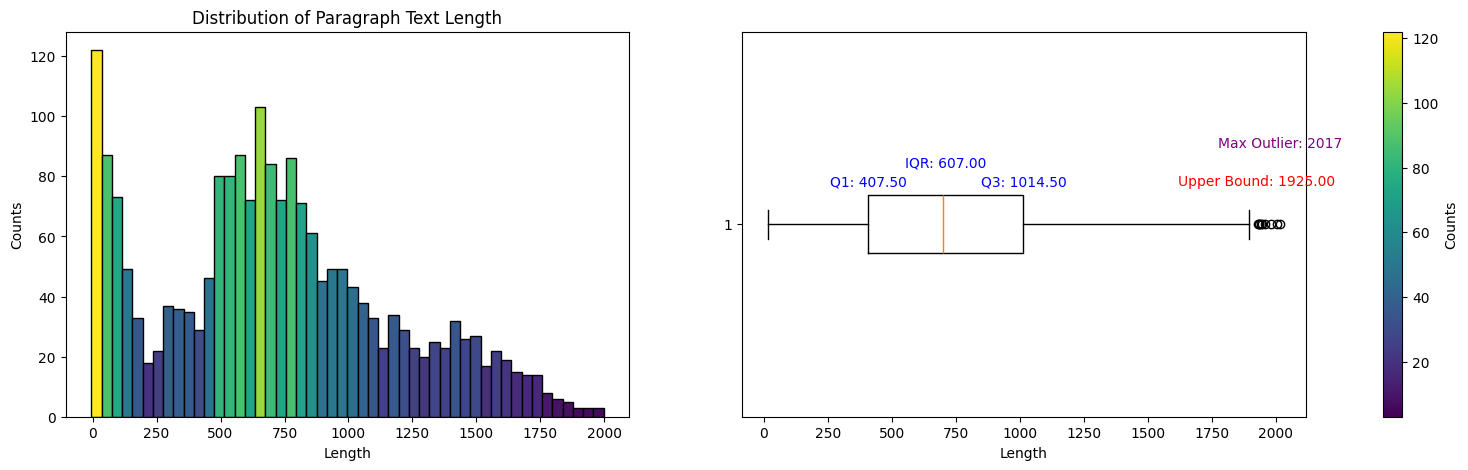

In [11]:
# 히스토그램 데이터 생성
counts, bins = np.histogram(lens_prg, bins=50)

# 막대의 색상 적용
colors = plt.cm.viridis(counts / counts.max())  # Viridis 색상 맵 사용

# 플롯
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
for i in range(len(bins) - 1):
    ax[0].bar(bins[i], counts[i], width=bins[i + 1] - bins[i], color=colors[i], edgecolor="black")

ax[0].set_title("Distribution of Paragraph Text Length")
ax[0].set_ylabel("Counts")
ax[0].set_xlabel("Length")

# 컬러바 추가
sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=counts.min(), vmax=counts.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Counts")

# 박스 플롯 생성

Q1 = np.percentile(lens_prg, 25)
Q3 = np.percentile(lens_prg, 75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

ax[1].boxplot(lens_prg, vert=False)
ax[1].set_xlabel("Length")

ax[1].text(Q1, 1.1, f"Q1: {Q1:.2f}", color="blue", ha="center")
ax[1].text(Q3, 1.1, f"Q3: {Q3:.2f}", color="blue", ha="center")
ax[1].text(upper_bound, 1.1, f"Upper Bound: {upper_bound:.2f}", color="red", ha="center")
ax[1].text((Q1 + Q3) / 2, 1.15, f"IQR: {IQR:.2f}", color="blue", ha="center", fontsize=10)


outliers = lens_prg[lens_prg > upper_bound]
max_outlier = outliers.max() if len(outliers) > 0 else None  # Check if there are any outliers

if max_outlier is not None:
    ax[1].text(max_outlier, 1.2, f"Max Outlier: {max_outlier}", color="purple", ha="center", fontsize=10)



plt.show()

해당 그림을 보았을 때, 길이가 최대 2017자인 경우도 있고, 최소의 경우 15자인 경우도 존재한다.  
예측으로는 2017자에는 국어 지문이 들어가는 것으로 이해됨

# Tokenizer 확인 및 Token 길이 확인

In [12]:
tokenizer = AutoTokenizer.from_pretrained("beomi/gemma-ko-2b")

In [13]:
# chat Template
tokenizer.chat_template = """
{% if messages[0]['role'] == 'system' %}
{% set system_message = messages[0]['content'] %}
{% endif %}
{% if system_message is defined %}
{{ system_message }}
{% endif %}
{% for message in messages %}
{% set content = message['content'] %}
{% if message['role'] == 'user' %}
{{ '<start_of_turn>user\n' + content + '<end_of_turn>\n<start_of_turn>model\n' }}
{% elif message['role'] == 'assistant' %}
{{ content + '<end_of_turn>\n' }}
{% endif %}
{% endfor %}"
"""


In [14]:
from ast import literal_eval
# Load the train dataset
# TODO Train Data 경로 입력
dataset = pd.read_csv(os.path.join(data_path,"train.csv") )

# Flatten the JSON dataset
records = []
for _, row in dataset.iterrows():
    problems = literal_eval(row['problems'])
    record = {
        'id': row['id'],
        'paragraph': row['paragraph'],
        'question': problems['question'],
        'choices': problems['choices'],
        'answer': problems.get('answer', None),
        "question_plus": problems.get('question_plus', None),
    }
    # Include 'question_plus' if it exists
    if 'question_plus' in problems:
        record['question_plus'] = problems['question_plus']
    records.append(record)
        
# Convert to DataFrame
df = pd.DataFrame(records)
dataset = Dataset.from_pandas(df)

In [15]:
PROMPT_NO_QUESTION_PLUS = """지문:
{paragraph}

질문:
{question}

선택지:
{choices}

1, 2, 3, 4, 5 중에 하나를 정답으로 고르세요.
정답:"""

PROMPT_QUESTION_PLUS = """지문:
{paragraph}

질문:
{question}

<보기>:
{question_plus}

선택지:
{choices}

1, 2, 3, 4, 5 중에 하나를 정답으로 고르세요.
정답:"""

In [16]:
processed_dataset = []
for i in range(len(dataset)):
    choices_string = "\n".join([f"{idx + 1} - {choice}" for idx, choice in enumerate(dataset[i]["choices"])])

    # <보기>가 있을 때
    if dataset[i]["question_plus"]:
        user_message = PROMPT_QUESTION_PLUS.format(
            paragraph=dataset[i]["paragraph"],
            question=dataset[i]["question"],
            question_plus=dataset[i]["question_plus"],
            choices=choices_string,
        )
    # <보기>가 없을 때
    else:
        user_message = PROMPT_NO_QUESTION_PLUS.format(
            paragraph=dataset[i]["paragraph"],
            question=dataset[i]["question"],
            choices=choices_string,
        )

    # chat message 형식으로 변환
    processed_dataset.append(
        {
            "id": dataset[i]["id"],
            "messages": [
                {"role": "system", "content": "지문을 읽고 질문의 답을 구하세요."},
                {"role": "user", "content": user_message},
                {"role": "assistant", "content": f"{dataset[i]['answer']}"}
            ],
            "label": dataset[i]["answer"],
        }
    )
processed_dataset = Dataset.from_pandas(pd.DataFrame(processed_dataset))

In [17]:
def formatting_prompts_func(example):
    output_texts = []
    for i in range(len(example["messages"])):
        output_texts.append(
            tokenizer.apply_chat_template(
                example["messages"][i],
                tokenize=False,
            )
        )
    return output_texts

def tokenize(element):
    outputs = tokenizer(
        formatting_prompts_func(element),
        truncation=False,
        padding=False,
        return_overflowing_tokens=False,
        return_length=False,
    )
    return {
        "input_ids": outputs["input_ids"],
        "attention_mask": outputs["attention_mask"],
    }

# 데이터 토큰화
tokenized_dataset = processed_dataset.map(
    tokenize,
    remove_columns=list(processed_dataset.features),
    batched=True,
    num_proc=4,
    load_from_cache_file=True,
    desc="Tokenizing",
)

Tokenizing (num_proc=4):   0%|          | 0/2031 [00:00<?, ? examples/s]

In [18]:
special_tokens = tokenizer.special_tokens_map
print(tokenizer.special_tokens_map)
for token_name, token in special_tokens.items():
    token_id = tokenizer.convert_tokens_to_ids(token)
    print(f"{token_name} ({token}): {token_id}")

{'bos_token': '<bos>', 'eos_token': '<eos>', 'unk_token': '<unk>', 'pad_token': '<pad>'}
bos_token (<bos>): 2
eos_token (<eos>): 1
unk_token (<unk>): 3
pad_token (<pad>): 0


```python
messages = [
    {"role": "system", "content": "System initialized."},
    {"role": "user", "content": "Hello, how are you?"},
    {"role": "assistant", "content": "I'm fine, thank you! How can I assist you today?"},
]
```
가 다음과 같이 변환됨

```php
System initialized.
<start_of_turn>user
Hello, how are you?<end_of_turn>
<start_of_turn>model
I'm fine, thank you! How can I assist you today?<end_of_turn>
```

Token 기반으로 분포도를 확인하자

In [19]:
len(tokenized_dataset["input_ids"]) # 총 2031개 데이터의 토큰들

2031

In [20]:
token_lens = []
for tokens in tokenized_dataset["input_ids"]:
    token_lens.append(len(tokens))

In [21]:
# 최대 토큰 갯수 확인
token_lens = np.array(token_lens)
len(token_lens[token_lens>1024])

372

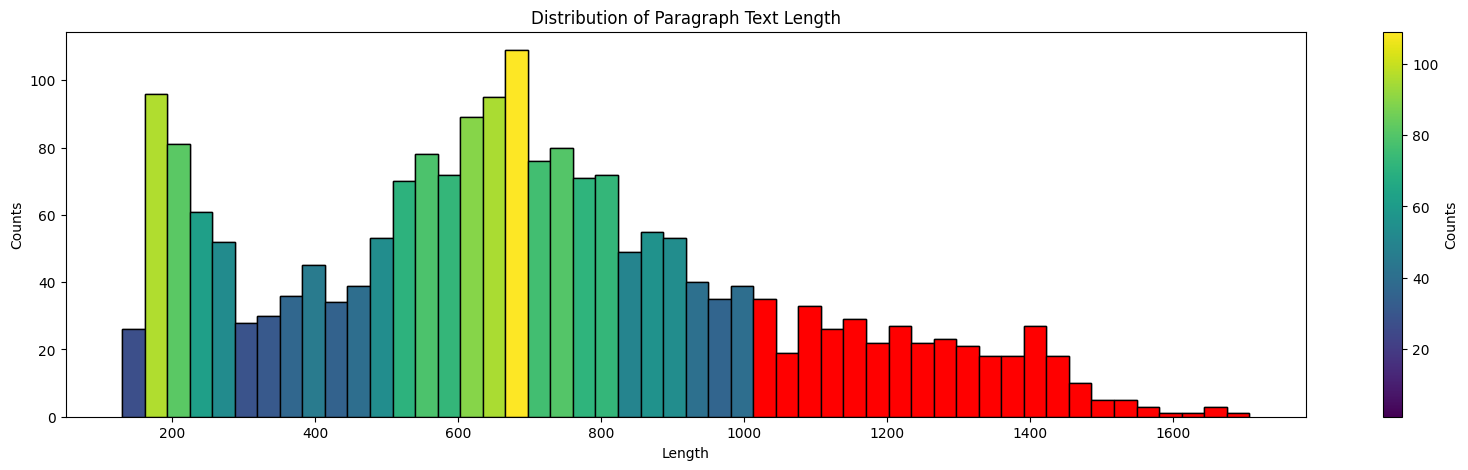

In [22]:
# 히스토그램 데이터 생성
counts, bins = np.histogram(token_lens, bins=50)

# 막대의 색상 적용
colors = plt.cm.viridis(counts / counts.max())  # Viridis 색상 맵 사용

# 플롯
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
for i in range(len(bins) - 1):
    ax.bar(bins[i], counts[i], width=bins[i + 1] - bins[i], color=colors[i], edgecolor="black")

ax.set_title("Distribution of Paragraph Text Length")
ax.set_ylabel("Counts")
ax.set_xlabel("Length")

# 컬러바 추가
sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=counts.min(), vmax=counts.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Counts")

length_threshold = 1024

for i in range(len(bins) - 1):
    if bins[i] >= length_threshold:
        ax.bar(bins[i], counts[i], width=bins[i + 1] - bins[i], color="red", edgecolor="black")
    else:
        ax.bar(bins[i], counts[i], width=bins[i + 1] - bins[i], color=colors[i], edgecolor="black")

In [23]:
# 1024 이상인 구간과 해당 데이터 찾기
indices = bins[:-1] >= length_threshold  # x축 길이가 1024 이상인 구간 찾기
exceeding_bins = bins[:-1][indices]      # 해당하는 x축 시작점 구간
exceeding_counts = counts[indices]       # 해당하는 구간의 데이터 개수

# 결과 출력
total_exceeding_data = exceeding_counts.sum()
print(f"x축 length가 {length_threshold} 이상인 데이터의 총 개수: {total_exceeding_data}")

x축 length가 1024 이상인 데이터의 총 개수: 367


총 데이터가 2031개 중 1024 token이 넘어가는 데이터 367개를 학습하지 못했었다.

그렇다면 `[UNK]` TOKEN은 몇개인가  
전체 토큰비율로 따지자

In [30]:
print("UNK Token is",tokenizer.unk_token_id)

UNK Token is 3


In [31]:
len_unk_tokens = 0
for tokens in tokenized_dataset["input_ids"]:
    unk_Counter = Counter(tokens)[3]
    len_unk_tokens += unk_Counter
print("UNK Tokens :",len_unk_tokens)

UNK Tokens : 0


놀랍게도 UNK Token가 없다...!